In [1]:
import tensorflow as tf
import pandas as pd
import math
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, Ridge
import numpy as np
#from keras.preprocessing.sequence import TimeseriesGenerator
from keras import Sequential
from keras.optimizers import Adam
from keras import layers

In [2]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (2).csv
Saving train.csv to train (2).csv


# Importing the Train data and dealing with Nan

In [3]:
train_data=pd.read_csv('train.csv')
train_data.info()

train_data=train_data.fillna(method='bfill')
train_data=train_data.fillna(method='ffill')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31875 entries, 0 to 31874
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   runDate             31875 non-null  object
 1   stations            31875 non-null  object
 2   trainCode           31875 non-null  int64 
 3   trainStationId      31875 non-null  int64 
 4   scheduledArrival    31184 non-null  object
 5   scheduledDeparture  31097 non-null  object
 6   actualArrival       31875 non-null  object
 7   actualDeparture     31775 non-null  object
 8   distance            31875 non-null  int64 
 9   dayCount            31875 non-null  int64 
 10  ArrivalDelay        31875 non-null  int64 
 11  DepartureDelay      31875 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 2.9+ MB


# Adding a weekday column to training data and dealing with categorical data

In [4]:
df_temp=train_data.select_dtypes(include=['object'])

import datetime 
import calendar 
  
def findDay(date):
    y=date[:4]
    m=date[5:7]
    d=date[8:10]
    date=d+' '+m+' '+y
    
    born = datetime.datetime.strptime(date, '%d %m %Y').weekday() 
    return (calendar.day_name[born]) 

df_temp['runDay']=df_temp['runDate'].apply(findDay)
mapping_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
df_temp['runDay']=df_temp['runDay'].map(mapping_dict)

##############

#Convert the arrival and departure timestamp into time 

##############

def find_time(timestamp):
    h=timestamp[11:13]
    m=timestamp[14:16]
    
    h=int(h)
    m=int(m)
    return h+0.01*m
train_data['scheduledArrival']=train_data['scheduledArrival'].apply(find_time)

train_data['scheduledDeparture']=train_data['scheduledDeparture'].apply(find_time)


### label encoding


le = preprocessing.LabelEncoder()
df_temp = df_temp.apply(le.fit_transform)

le1=preprocessing.LabelEncoder()

train_code_labeled = le1.fit_transform(train_data[['trainCode']])

pd_temp=pd.DataFrame(train_code_labeled,columns=['trainCode'])#,'runDate','scheduledArrival','scheduledDeparture'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

# final training dataframe to work with

In [5]:
new_df=pd.DataFrame(df_temp['stations']/100)
new_df=new_df.join(train_data['distance'])
new_df=new_df.join(df_temp['runDay'])
new_df=new_df.join(pd_temp['trainCode'])
new_df=new_df.join(df_temp['runDate'])
new_df=new_df.join(train_data['scheduledArrival'])
new_df=new_df.join(train_data['scheduledDeparture'])
new_df=new_df.join(train_data['ArrivalDelay'])
new_df=new_df.join(train_data['DepartureDelay'])

# Spliting into train and test data and adding previous station delay as a added feature

In [6]:
train_list=new_df['trainCode'].unique()
for i in train_list:
    
    temp_df=new_df[new_df['trainCode']==i]
    dates_list=temp_df['runDate'].unique()
    num_dates=len(dates_list)
    train_dates=dates_list[:math.ceil(4*num_dates/5)]
    test_dates=dates_list[len(train_dates):]
    
    for j in train_dates:
        try:
            temp_df_1=temp_df[temp_df['runDate']==j]
            
            num_stations=temp_df_1[temp_df_1['runDate']==j].shape[0]
            
            temp_df_1['prev_arrival_delay']=0*temp_df_1['ArrivalDelay']
            
            temp_df_1['prev_arrival_delay'][1:num_stations]=temp_df_1['ArrivalDelay'][:-1]

            temp_df_1['prev_departure_delay']=0*temp_df_1['DepartureDelay']

            temp_df_1['prev_departure_delay'][1:num_stations]=temp_df_1['DepartureDelay'][:-1]
            train_df=[train_df,temp_df_1]
            
            train_df=pd.concat(train_df)
        
        except:
            
            temp_df_1=temp_df[temp_df['runDate']==j]
            
            num_stations=temp_df_1[temp_df_1['runDate']==j].shape[0]
            
            temp_df_1['prev_arrival_delay']=0*temp_df_1['ArrivalDelay']
            
            temp_df_1['prev_arrival_delay'][1:num_stations]=temp_df_1['ArrivalDelay'][:-1]

            temp_df_1['prev_departure_delay']=0*temp_df_1['DepartureDelay']

            temp_df_1['prev_departure_delay'][1:num_stations]=temp_df_1['DepartureDelay'][:-1]

            train_df=temp_df_1

        
    for j in test_dates:
        try:
            test_df=[test_df,temp_df[temp_df['runDate']==j]]
            test_df=pd.concat(test_df)
        except:
            test_df=temp_df[temp_df['runDate']==j]     

Streaming output truncated to the last 5000 lines.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying 

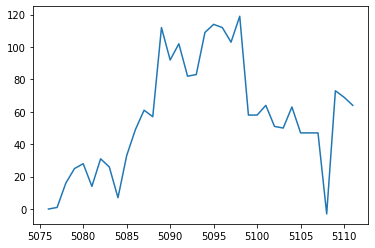

In [7]:
#### Data visulization for train 3 at one station 

train_list=new_df['trainCode'].unique()
viz_df=new_df[new_df['trainCode']==train_list[2]]

dates_list=viz_df['runDate'].unique()
single_date=viz_df[viz_df['runDate']==dates_list[10]]
single_date['ArrivalDelay'].plot()

In [8]:
train_x_data=train_df[['distance','stations','runDay','trainCode','runDate','scheduledArrival','scheduledDeparture','prev_arrival_delay','prev_departure_delay']]
test_x_data=test_df[['distance','stations','runDay','trainCode','runDate','scheduledArrival','scheduledDeparture']]

train_y_data=train_df[['ArrivalDelay','DepartureDelay']]
test_y_data=test_df[['ArrivalDelay','DepartureDelay']]


In [9]:
train_x_data.head()

,distance,stations,runDay,trainCode,runDate,scheduledArrival,scheduledDeparture,prev_arrival_delay,prev_departure_delay
0,0,1.28,3,0,0,22.05,21.40,0,0
1,32,1.24,3,0,0,22.05,22.07,0,0
2,45,1.75,3,0,0,22.23,22.25,11,11
3,61,1.36,3,0,0,22.38,22.40,14,13
4,76,1.38,3,0,0,22.54,22.56,18,17


# Converting the train dataframe into array and zero padding it into a batch size of 65

In [10]:


new_df=train_x_data
train_list=new_df['trainCode'].unique()
for i in train_list:
    
    temp_df=new_df[new_df['trainCode']==i]
    
    dates_list=temp_df['runDate'].unique()

    for j in dates_list:
        try:
            temp_df_1=temp_df[temp_df['runDate']==j]
            num_stations=temp_df_1.shape[0]
            
            arr=temp_df_1.to_numpy()
            if num_stations<65:
                arr=np.concatenate([arr,np.zeros([65-num_stations,temp_df_1.shape[1]])])
            train_x_arr=np.concatenate([train_x_arr,arr])
            temp_y_df=train_df[train_df['trainCode']==i]
            temp_y_df=temp_y_df[temp_y_df['runDate']==j]
            temp_y_arr=temp_y_df[['ArrivalDelay','DepartureDelay']].to_numpy()
            
            if num_stations<65:
                temp_y_arr=np.concatenate([temp_y_arr,np.zeros([65-num_stations,2])])
                
            train_y_arr=np.concatenate([train_y_arr,temp_y_arr])

        except:
            temp_df_1=temp_df[temp_df['runDate']==j]
            num_stations=temp_df_1.shape[0]
            
            arr=temp_df_1.to_numpy()
            if num_stations<65:
                arr=np.concatenate([arr,np.zeros([65-num_stations,temp_df_1.shape[1]])])
            train_x_arr=arr
             
            temp_y_df=train_df[train_df['trainCode']==i]
            temp_y_df=temp_y_df[temp_y_df['runDate']==j]
            temp_y_arr=temp_y_df[['ArrivalDelay','DepartureDelay']].to_numpy()
            
            if num_stations<65:
                temp_y_arr=np.concatenate([temp_y_arr,np.zeros([65-num_stations,2])])
           
            train_y_arr=temp_y_arr


# LSTM model definition with input size (65,9)

In [38]:
model=Sequential()
model.add(layers.LSTM(160,input_shape=(65,9),return_sequences=True))
model.add(layers.LeakyReLU(alpha=0.5))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(100,return_sequences=True))
model.add(layers.LeakyReLU(alpha=0.5))
model.add(layers.Dropout(0.3))


model.add(layers.LSTM(100,return_sequences=True))
model.add(layers.LeakyReLU(alpha=0.5))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(2))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 65, 160)           108800    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 65, 160)           0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 65, 160)           0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 65, 100)           104400    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 65, 100)           0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 65, 100)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 65, 100)          

In [39]:
x_train = train_x_arr.reshape(-1, 65, 9)
y_train  = train_y_arr.reshape(-1, 65, 2)
from keras.optimizers import SGD
#opt = SGD(lr=0.01, momentum=0.9)
opt_adam = Adam(learning_rate=0.01)
#model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])
model.compile(loss='mean_absolute_error', optimizer=opt_adam,metrics=['mse'])
# fit model
history = model.fit(x_train, y_train,epochs=800, verbose=0)


In [40]:
model.evaluate(x_train,y_train)


18/18 [==============================] - 1s 6ms/step - loss: 4.9121 - mse: 202.1961


[4.912143230438232, 202.19607543945312]

# Now predict delays for current station info and use it to predict the next station

In [41]:
def generate_delay(model, in_data):
    input_x=np.append(in_data[0:1].to_numpy(),[0,0]).reshape(-1,1,9)
    y1=np.array([0,0])
    out=np.array([])

    num_stations=in_data.shape[0]
    for i in np.arange(1,num_stations):
        out = model.predict(input_x).reshape(1,2)
        y1=np.vstack((y1,out))
        #print(np.append(in_data[i:i+1].to_numpy(),out))
        input_x=np.append(in_data[i:i+1].to_numpy(),out).reshape(-1,1,9)
    return y1

# Generate the output array

In [44]:
#Generate the output array

train_list=test_x_data['trainCode'].unique()

for i in train_list:
    temp_df=test_x_data[test_x_data['trainCode']==i]

    dates_list=temp_df['runDate'].unique()
    
    for j in dates_list:
        in_data=temp_df[temp_df['runDate']==j]
        temp=generate_delay(model,in_data)
        try:
            out=np.vstack((out,temp))
        except:
            out=temp

In [45]:
from sklearn.metrics import mean_squared_error 
mean_squared_error(test_y_data,out) 

5100.025691551209

# Experiment with Logistic Regression with the padded dataset 
### Definitely would like to try other ML models on non-padded data)

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

lreg=MultiOutputRegressor(Ridge(random_state=1,max_iter=1000)).fit(train_x_data,train_y_data)


   ArrivalDelay  DepartureDelay
0             0               0
1            11              11
2            14              13
3            18              17
4            20              19
5             6               1
6            11              11
7            15              15
8            15              15
9            15              15


In [ ]:
def generate_delay(model, in_data):
    input_x=np.append(in_data[0:1].to_numpy(),[0,0]).reshape(1,9)
    y1=np.array([0,0])
    out=np.array([])

    num_stations=in_data.shape[0]
    for i in np.arange(1,num_stations):
        out = model.predict(input_x).reshape(1,2)
        y1=np.vstack((y1,out))
        input_x=np.append(in_data[i:i+1].to_numpy(),out).reshape(1,9)
    return y1

In [ ]:
train_list=test_x_data['trainCode'].unique()

for i in train_list:
    temp_df=test_x_data[test_x_data['trainCode']==i]

    dates_list=temp_df['runDate'].unique()
    
    for j in dates_list:
        in_data=temp_df[temp_df['runDate']==j]
        temp=generate_delay(lreg,in_data)
        try:
            out=np.vstack((out,temp))
        except:
            out=temp

In [ ]:
print(test_y_data[0:10],out)
from sklearn.metrics import mean_squared_error 
mean_squared_error(test_y_data,out) 

      ArrivalDelay  DepartureDelay
2160             0               0
2161             8               7
2162            11              11
2163            15              14
2164            18              18
2165             7               2
2166            24              24
2167            29              29
2168            29              28
2169            29              29 [[ 0.          0.        ]
 [ 0.11887197  4.98042338]
 [ 4.92272417  9.03231968]
 ...
 [ 2.33543622  4.18483214]
 [ 1.35472312  3.20337668]
 [-0.03923669  1.81915686]]


4600.386842433747

# Test data prediction

In [46]:
test_data=pd.read_csv('test.csv')

test_data=test_data.fillna(method='bfill')
test_data=test_data.fillna(method='ffill')


df_temp_test=test_data.select_dtypes(include=['object'])

df_temp_test['runDay']=df_temp_test['runDate'].apply(findDay)

df_temp_test['runDay']=df_temp_test['runDay'].map(mapping_dict)

test_data['scheduledArrival']=test_data['scheduledArrival'].apply(find_time)

test_data['scheduledDeparture']=test_data['scheduledDeparture'].apply(find_time)
le = preprocessing.LabelEncoder()
df_temp_test = df_temp_test.apply(le.fit_transform)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [47]:
min_max_scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.MinMaxScaler()
temp_df_scale=test_data[['trainCode']]#,'runDate','scheduledArrival','scheduledDeparture']]

x_scaled = 100*min_max_scaler.fit_transform(temp_df_scale)

pd_temp=pd.DataFrame(x_scaled,columns=['trainCode'])#,'runDate','scheduledArrival','scheduledDeparture'])

pd_temp.head()

new_df=pd.DataFrame(df_temp_test['stations'])
new_df=new_df.join(test_data['distance'])
new_df=new_df.join(df_temp_test['runDay'])
new_df=new_df.join(pd_temp['trainCode'])
new_df=new_df.join(df_temp_test['runDate'])
new_df=new_df.join(test_data['scheduledArrival'])
new_df=new_df.join(test_data['scheduledDeparture'])



test_df=new_df

In [48]:
def generate_delay(model, in_data):
    input_x=np.append(in_data[0:1].to_numpy(),[0,0]).reshape(-1,1,9)
    y1=np.array([0,0])
    out=np.array([])

    num_stations=in_data.shape[0]
    for i in np.arange(1,num_stations):
        out = model.predict(input_x).reshape(1,2)
        y1=np.vstack((y1,out))
        input_x=np.append(in_data[i:i+1].to_numpy(),out).reshape(-1,1,9)
    return y1

In [49]:
train_list=test_df['trainCode'].unique()

for i in train_list:
    temp_df=test_df[test_df['trainCode']==i]

    dates_list=temp_df['runDate'].unique()
    
    for j in dates_list:
        in_data=temp_df[temp_df['runDate']==j]
        temp=generate_delay(model,in_data)
        try:
            out=np.vstack((out,temp))
        except:
            out=temp

In [50]:
out=pd.DataFrame(out)

In [51]:
out.to_csv('output.csv',index=False) 

In [52]:
out.head

<bound method NDFrame.head of              0         1
0     0.000000  0.000000
1     0.000908  0.032349
2     0.912497  1.206717
3     1.126640  1.463178
4     1.019211  1.387586
...        ...       ...
6834  5.023470  5.096952
6835  8.050213  8.077787
6836  4.065350  4.116773
6837  4.064925  4.116769
6838  3.724351  3.785427

[6839 rows x 2 columns]>

In [53]:
te=pd.read_csv('output.csv')
te.head()

,0,1
0,0.000000,0.000000
1,0.000908,0.032349
2,0.912497,1.206717
3,1.126640,1.463178
4,1.019211,1.387586
